In [1]:
%matplotlib inline
import time 
from qutip import mesolve, steadystate
import numpy as np
import optical as EM
import phonons as RC
import leads as FL
from utils import *
from photocell_setup import *
import matplotlib.pyplot as plt
#from importlib import reload

utils imported


In [2]:
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = "-"
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics} ')
colours = ['#1E90FF', '#3CB371', '#FFA500', '#FF0000']

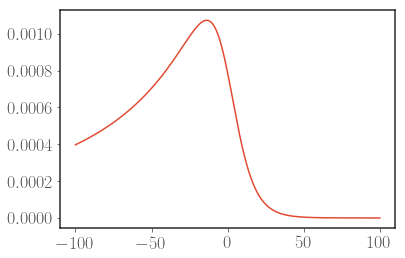

In [3]:
w = np.linspace(-100, 100, 1000)
plt.plot(w, FL.J_Lorentzian(w, 10, 100, Gamma=1)*FL.fermi_occ(w, 10, 0.) )
#plt.plot(w, FL.J_Lorentzian(w, 10,100,Gamma=1)*(1-FL.fermi_occ(w, 10, 0.)))
#plt.plot(w, J_underdamped(w, 10,10,alpha=1/(2*pi)) )
plt.show()

In [4]:
reload(RC)
reload(EM)
reload(FL)

def dynamics( H, L, PARAMS, tf=10, tN=1000):
    timelist = np.linspace(0, tf, tN)
    ops = make_expectation_operators(PARAMS)
    rho_0 = tensor(0.5*(exciton_ket+vac_ket)*(exciton_ket.dag()+vac_ket.dag()), 
                   thermal_dm(PARAMS['N'], Occupation(PARAMS['Omega_RC'], PARAMS['T_ph'])))
    data = mesolve(H, rho_0, timelist, c_ops=[L], e_ops=[ops['exciton'], ops['real_coherence'], 
                                                         ops['imag_coherence']], 
                   options=qt.Options(nsteps=15000))
    plt.figure()
    plt.plot(timelist, data.expect[0])
    plt.figure()
    plt.plot(timelist, data.expect[1])
    plt.show()

def build_full_L(PARAMS, silent=True):
    # RC mapping on operators etc
    PARAMS, L_RC, H_S, A_nrwa, A_RC, A_L, A_R = RC.RC_mapping(PARAMS, silent=silent)
    H = H_S # H_S
    H_add = tensor(PARAMS['H_sub'], qeye(PARAMS['N']))
    # optical liouv and additive
    if PARAMS['radiative_lifetime'] == np.infty:
        L_EM_add = L_EM = 0
    else:
        L_EM = EM.L_non_rwa(H_S, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
    
    #  Left and right leads and additive
    #L_L, L_R = FL.L_R_lead_dissipators(H_S, PARAMS, real_only=False, silent=False)
    L_L, L_R = FL.L_R_lead_dissipators(H, PARAMS, silent=silent)
    # dict of various combinations    
    L_dict = {'PARAMS': PARAMS, 'H_S': H_S, 'L_EM': L_EM, 'L_R': L_R, 
                                            'L_full' : L_EM+L_L+L_R+L_RC}
    return L_dict # dict

def build_Lindblad_L(PARAMS, silent=True):
    # RC mapping on operators etc
    PARAMS, L_RC, H_S, A_nrwa, A_RC, A_L, A_R = RC.RC_mapping(PARAMS, silent=silent)
    H = H_S # H_S
    H_add = tensor(PARAMS['H_sub'], qeye(PARAMS['N']))
    # optical liouv and additive
    if PARAMS['radiative_lifetime'] == np.infty:
        L_EM_add = L_EM = 0
    else:
        L_EM = EM.L_non_rwa(H_S, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
        L_EM_add = EM.L_non_rwa(H_add, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'], silent=silent, tol=0)
    #  Left and right leads and additive
    #L_L, L_R = FL.L_R_lead_dissipators(H_S, PARAMS, real_only=False, silent=False)
    L_L_lindblad, L_R_lindblad = L_left_and_right_secular(H, PARAMS)
    # dict of various combinations    
    L_dict = {'PARAMS': PARAMS, 'H_S': H_S, 'L_EM': L_EM, 'L_R_lindblad': L_R_lindblad, 
                                            'L_lindblad' : L_EM+L_L_lindblad+L_R_lindblad+L_RC,
                                             'L_lindblad_add_EM' : L_EM_add+L_L_lindblad+L_R_lindblad+L_RC}
    return L_dict # dict

def build_all_L(PARAMS, silent=True):
    # RC mapping on operators etc
    PARAMS, L_RC, H_S, A_nrwa, A_RC, A_L, A_R = RC.RC_mapping(PARAMS, silent=silent)
    H = H_S # H_S
    H_add = tensor(PARAMS['H_sub'], qeye(PARAMS['N']))
    # optical liouv and additive
    if PARAMS['radiative_lifetime'] == np.infty:
        L_EM_add = L_EM = 0
    else:
        L_EM = EM.L_non_rwa(H_S, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                            PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
        L_EM_add = EM.L_non_rwa(H_add, A_nrwa, PARAMS['omega_exciton'], PARAMS['Gamma_EM'], 
                                PARAMS['T_EM'], PARAMS['J'],
                                    silent=silent, tol=0)
    
    #  Left and right leads and additive
    L_L, L_R = FL.L_R_lead_dissipators(H, PARAMS, silent=silent)
    L_L_lindblad, L_R_lindblad = L_left_and_right_secular(H, PARAMS)
    L_L_add, L_R_add = FL.L_left_nonadditive(H_add, PARAMS), FL.L_right_nonadditive(H_add, PARAMS)
    # dict of various combinations    
    L_dict = {'PARAMS': PARAMS, 'H_S': H_S, 'L_EM': L_EM, 'L_R': L_R, 'L_R_lindblad': L_R_lindblad,
                                            'L_full' : L_EM+L_L+L_R+L_RC,
                                            'L_lindblad' : L_EM+L_L_lindblad+L_R_lindblad+L_RC,
                                            'L_add_EM' : L_EM_add+L_R+L_L+L_RC,
                                            'L_add_leads' : L_EM+L_L_add+L_R_add+L_RC,
                                            'L_no_EM' : L_R+L_L+L_RC}
    return L_dict # dict
#return H_S, L_RC, L_EM, L_EM_add, L_L, L_R, L_L_add, L_R_add



In [1]:
def secular_term(state_j, state_k):
    jk = state_j*state_k.dag()
    kj = jk.dag()
    jj = state_j*state_j.dag()
    return 2*sprepost(kj, jk) - (spre(jj) + spost(jj))

def L_left_and_right_secular(H, PARAMS):
    ti = time.time()
    energies, states = H.eigenstates()
    A_R = tensor(PARAMS['A_R'], qeye(PARAMS['N']))
    A_L = tensor(PARAMS['A_L'], qeye(PARAMS['N']))
    H_dim = len(energies)
    Lambda_up_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='p', real_only=True)
    Lambda_down_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='m', real_only=True)
    
    Lambda_up_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='p', real_only=True)
    Lambda_down_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='m', real_only=True)
    
    L_L = L_R = 0
    for j in range(H_dim):
        for k in range(H_dim):
            omega_jk = energies[j]-energies[k]
            state_j, state_k = states[j], states[k]
            
            A_dag_jk = A_R.dag().matrix_element(state_j, state_k)
            A_kj = A_R.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_R += Lambda_down_R(omega_jk)*coeff*secular_term(state_j, state_k)
                L_R += Lambda_up_R(omega_jk)*coeff*secular_term(state_k, state_j)
            
            A_dag_jk = A_L.dag().matrix_element(state_j, state_k)
            A_kj = A_L.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_L += Lambda_up_L(-omega_jk)*coeff*secular_term(state_j, state_k)
                L_L += Lambda_down_L(-omega_jk)*coeff*secular_term(state_k, state_j)
    #print(time.time() - ti)
    return L_L, L_R

In [6]:
def L_left_and_right_electronic(PARAMS):
    ti = time.time()
    energies, states = PARAMS['H_sub'].eigenstates()
    A_R = d_e
    A_L = d_h
    H_dim = len(energies)
    Lambda_up_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='p', real_only=True)
    Lambda_down_R = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_R'], PARAMS['T_R'], PARAMS['Gamma_R'], 
                                                    PARAMS['delta_R'], PARAMS['Omega_R'], type='m', real_only=True)
    
    Lambda_up_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='p', real_only=True)
    Lambda_down_L = lambda x :  FL.Lamdba_complex_rate(x, FL.J_Lorentzian, PARAMS['mu_L'], PARAMS['T_L'], PARAMS['Gamma_L'], 
                                                    PARAMS['delta_L'], PARAMS['Omega_L'], type='m', real_only=True)
    
    L_L = L_R = 0
    for j in range(H_dim):
        for k in range(H_dim):
            omega_jk = energies[j]-energies[k]
            state_j, state_k = states[j], states[k]
            
            A_dag_jk = A_R.dag().matrix_element(state_j, state_k)
            A_kj = A_R.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_R += Lambda_down_R(omega_jk)*coeff*secular_term(state_j, state_k)
                L_R += Lambda_up_R(omega_jk)*coeff*secular_term(state_k, state_j)
            
            A_dag_jk = A_L.dag().matrix_element(state_j, state_k)
            A_kj = A_L.matrix_element(state_k, state_j)
            coeff = A_dag_jk*A_kj
            if np.abs(coeff) > 0:
                L_L += Lambda_up_L(-omega_jk)*coeff*secular_term(state_j, state_k)
                L_L += Lambda_down_L(-omega_jk)*coeff*secular_term(state_k, state_j)
    #print(time.time() - ti)
    return L_L, L_R

In [120]:
def current_from_L(L_dict, n_c_RC):
    ss = steadystate(L_dict['H_S'], [L_dict['L_lindblad']])
    return -(qt.vector_to_operator(L_dict['L_R']*qt.operator_to_vector(ss))*n_c_RC).tr()

def current_from_ss(ss, L_R, n_c_RC):
    return -(qt.vector_to_operator(L_R*qt.operator_to_vector(ss))*n_c_RC).tr()

def current_and_obs_from_L(H, L_full, L_track, obs_ops):
    obs_out = []
    rho_ss = qt.steadystate(H, [L_full])
    obs_out.append(-(qt.vector_to_operator(L_track*qt.operator_to_vector(rho_ss))*obs_ops[0]).tr())
    for obs in obs_ops[1::]:
        obs_out.append((rho_ss*obs).tr())
    del rho_ss
    return obs_out

def band_populations_vs_voltage(PARAMS, x_scale=1):
    #bias_voltages = [0, 0.5, 1]
    bias_voltages = np. linspace(0, PARAMS['omega_exciton']*x_scale, 100)
    conduction_population = []
    valence_population = []
    for i, bv in enumerate(bias_voltages):
        PARAMS.update({'mu_R': PARAMS['mu']+bv/2, 'mu_L': PARAMS['mu']-bv/2})
        #if i in [10, 90]:
        #    print_PARAMS(PARAMS)
        L_Lindblad_dict = build_Lindblad_L(PARAMS, silent=True)
        #ops = make_expectation_operators(PARAMS)
        n_c = tensor(d_e.dag()*d_e, qeye(PARAMS['N']))
        n_v = tensor(d_h.dag()*d_h, qeye(PARAMS['N']))
        ss = steadystate(L_Lindblad_dict['H_S'], [L_Lindblad_dict['L_lindblad']])
        if i in [10, 90]:
            print( ss.ptrace(0) )
        conduction_population.append((n_c*ss).tr())
        valence_population.append((n_v*ss).tr())
    bias_voltages/=ev_to_inv_cm
    return bias_voltages, conduction_population, valence_population

def simple_current_vs_voltage(PARAMS, x_scale=1):
    bias_voltages = np. linspace(0, PARAMS['omega_exciton']*x_scale, 150)
    currents = []
    for i, bv in enumerate(bias_voltages):
        PARAMS.update({'mu_R': PARAMS['mu']+bv/2, 'mu_L': PARAMS['mu']-bv/2})
        #if i in [10, 90]:
        #    print_PARAMS(PARAMS)
        L_Lindblad_dict = build_Lindblad_L(PARAMS, silent=True)
        #ops = make_expectation_operators(PARAMS)
        n_c = tensor(d_e.dag()*d_e, qeye(PARAMS['N']))
        ss = steadystate(L_Lindblad_dict['H_S'], [L_Lindblad_dict['L_lindblad']])
        currents.append(current_from_ss(ss, L_Lindblad_dict['L_R_lindblad'], n_c))
        
        if i in [10, 90]:
            print( ss.ptrace(0) )
            print_PARAMS(PARAMS)
    bias_voltages/=ev_to_inv_cm
    return bias_voltages, currents

def observables_and_current_vs_voltage(PARAMS, x_scale=2):
    ti = time.time()
    bias_voltages = np. linspace(0, PARAMS['omega_exciton']*x_scale, 180)
    current = []
    conduction_population = []
    valence_population = []
    for i, bv in enumerate(bias_voltages):
        PARAMS.update({'mu_R': PARAMS['mu']+bv/2, 'mu_L': PARAMS['mu']-bv/2})
        #if i in [10, 90]:
        #    print_PARAMS(PARAMS)
        L_Lindblad_dict = build_Lindblad_L(PARAMS, silent=True)
        #ops = make_expectation_operators(PARAMS)
        n_c = tensor(d_e.dag()*d_e, qeye(PARAMS['N']))
        n_v = tensor(d_h.dag()*d_h, qeye(PARAMS['N']))
        ss = steadystate(L_Lindblad_dict['H_S'], [L_Lindblad_dict['L_lindblad']])
        current.append(current_from_ss(ss, L_Lindblad_dict['L_R_lindblad'], n_c))
        conduction_population.append((n_c*ss).tr())
        valence_population.append((n_v*ss).tr())
    bias_voltages/=ev_to_inv_cm
    data_dict = {'bias_voltages':bias_voltages, 
                 'current': current,
                 'conduction_population' : conduction_population, 
                 'valence_population' : valence_population,
                'PARAMS': PARAMS}
    print("C-V data calculated in {:0.1f} seconds".format(time.time() - ti))
    return data_dict

def populations_and_current_vs_voltage(PARAMS, x_scale=1.8):
    ti = time.time()
    if PARAMS['T_L']<100:
        number_of_voltages = 180
    else:
        number_of_voltages = 100
    bias_voltages = np. linspace(0, PARAMS['omega_exciton']*x_scale, number_of_voltages)
    current = []
    conduction_population = []
    valence_population = []
    ground_population = []
    hole_population = []
    electron_population = []
    exciton_population = []
    ops = make_expectation_operators(PARAMS)
    for i, bv in enumerate(bias_voltages):
        PARAMS.update({'mu_R': PARAMS['mu']+bv/2, 'mu_L': PARAMS['mu']-bv/2})
        #if i in [10, 90]:
        #    print_PARAMS(PARAMS)
        L_Lindblad_dict = build_Lindblad_L(PARAMS, silent=True)
        #ops = make_expectation_operators(PARAMS)
        n_c = tensor(d_e.dag()*d_e, qeye(PARAMS['N']))
        n_v = tensor(d_h.dag()*d_h, qeye(PARAMS['N']))
        ss = steadystate(L_Lindblad_dict['H_S'], [L_Lindblad_dict['L_lindblad']])
        current.append(current_from_ss(ss, L_Lindblad_dict['L_R_lindblad'], n_c))
        conduction_population.append((n_c*ss).tr())
        valence_population.append((n_v*ss).tr())
        ground_population.append((ops['vac']*ss).tr())
        hole_population.append((ops['hole']*ss).tr())
        electron_population.append((ops['electron']*ss).tr())
        exciton_population.append((ops['exciton']*ss).tr())
    bias_voltages/=ev_to_inv_cm
    data_dict = {'bias_voltages':bias_voltages, 
                 'current': current,
                 'conduction_population' : conduction_population, 
                 'valence_population' : valence_population,
                 'ground_population': ground_population,
                 'hole_population' : hole_population,
                 'electron_population' : electron_population,
                 'exciton_population' : exciton_population,
                'PARAMS': PARAMS}
    print("C-V data calculated in {:0.1f} seconds".format(time.time() - ti))
    return data_dict

In [67]:
plt.rc('grid', linestyle="--", color='grey')
def plot_diagrams(data_dict, y_values='bias_voltage', xlim_lower=None, xlim_higher=None):
    _PARAMS = data_dict['PARAMS']
    if PARAMS['mu'] < (_PARAMS['omega_c']-_PARAMS['omega_v'])/2:
        mu_R_backflow_threshold = 2*_PARAMS['mu']+_PARAMS['omega_v']
    else:
        mu_R_backflow_threshold = _PARAMS['omega_c']
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12), sharex=True)
    if y_values == 'mu_L':
        X = np.array([_PARAMS['mu']-bv/2 for bv in data_dict['bias_voltages']*ev_to_inv_cm])
        ax2.axvline(-(_PARAMS['omega_v']-_PARAMS['binding_energy']), linestyle='dotted', color='blue')
        ax2.axvline((2*_PARAMS['mu']-(mu_R_backflow_threshold)), 
                    linestyle='dotted', color='red')
        
        if abs(_PARAMS['binding_energy'])>0:
            ax2.axvline(2*_PARAMS['mu']-(_PARAMS['omega_c']-_PARAMS['binding_energy']), 
                        linestyle='dotted', color='yellow')
    elif y_values == 'mu_R':
        X = [_PARAMS['mu']+bv/2 for bv in data_dict['bias_voltages']*ev_to_inv_cm]
        ax2.axvline(2*_PARAMS['mu']+_PARAMS['omega_v']-_PARAMS['binding_energy'], 
                    linestyle='dotted', color='blue')
        ax2.axvline(mu_R_backflow_threshold, linestyle='dotted', color='red')
        if abs(_PARAMS['binding_energy'])>0:
            ax2.axvline(_PARAMS['omega_c']-_PARAMS['binding_energy'], linestyle='dotted', color='yellow')
    elif y_values == 'bias_voltage':
        X = data_dict['bias_voltages']*ev_to_inv_cm
        ax2.axvline(2*(_PARAMS['mu']+_PARAMS['omega_v']-_PARAMS['binding_energy']), 
                    linestyle='dotted', color='blue')
        if PARAMS['mu'] < (_PARAMS['omega_c']-_PARAMS['omega_v'])/2:
            if abs(_PARAMS['binding_energy'])<(2*_PARAMS['mu']-_PARAMS['bandgap']):
                ax2.axvline(2*(_PARAMS['mu']+_PARAMS['omega_v']-_PARAMS['binding_energy']), 
                            linestyle='dotted', color='red')
        else:
            ax2.axvline(2*(mu_R_backflow_threshold-_PARAMS['mu']), linestyle='dotted', color='red')
        if abs(_PARAMS['binding_energy'])>0:
            
            ax2.axvline(2*(_PARAMS['omega_c']-_PARAMS['binding_energy']-_PARAMS['mu']), 
                        linestyle='dotted', color='yellow')
    ax1.plot(X, np.array(data_dict['conduction_population']).real, label=r'$n_c$')
    ax1.plot(X, np.array(data_dict['valence_population']).real, label=r'$n_v$')
    #ax1.plot(X, np.array(data_dict['ground_population']).real, label=r'v')
    #ax1.plot(X, np.array(data_dict['hole_population']).real, label=r'h')
    #ax1.plot(X, np.array(data_dict['electron_population']).real, label=r'e')
    #ax1.plot(X, np.array(data_dict['exciton_population']).real, label=r'exc')
    ax1.legend()
    ax2.plot(X, np.array(data_dict['current']).real)
    ax1.set_xlim(xlim_lower, xlim_higher)
    

In [121]:
def plot_voltage_current(data_dict):
    # if 
    _PARAMS = data_dict['PARAMS']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,12), sharex=True)
    
    X = data_dict['bias_voltages']*ev_to_inv_cm
    red_mu_R, red_mu_L = _PARAMS['omega_c'], 2*_PARAMS['mu']-_PARAMS['omega_c']
    blue_mu_R  = 2*_PARAMS['mu']+(_PARAMS['omega_v']-_PARAMS['binding_energy'])
    blue_mu_L = -(_PARAMS['omega_v']-_PARAMS['binding_energy'])
    
    
    if abs(_PARAMS['binding_energy'])>0:
        yellow_mu_R = _PARAMS['omega_c']-_PARAMS['binding_energy']
        yellow_mu_L = 2*_PARAMS['mu']-(_PARAMS['omega_c']-_PARAMS['binding_energy'])
        ax2.axvline(yellow_mu_R - yellow_mu_L, linestyle='dotted', color='yellow')
        if _PARAMS['mu']<(_PARAMS['bandgap']/2):
            red_mu_R = 2*_PARAMS['mu']+_PARAMS['omega_v']
            red_mu_L = 2*_PARAMS['mu']-(red_mu_R)
    ax2.axvline(blue_mu_R-blue_mu_L, linestyle='dotted', color='blue')
    ax2.axvline(red_mu_R-red_mu_L, linestyle='dotted', color='red')
    ax1.plot(X, np.array(data_dict['conduction_population']).real, label=r'$n_c$')
    ax1.plot(X, np.array(data_dict['valence_population']).real, label=r'$n_v$')
    ax2.set_xlabel('Bias voltage')
    ax1.set_ylabel('Population')
    ax2.set_ylabel('Current')
    #ax1.plot(X, np.array(data_dict['ground_population']).real, label=r'v')
    #ax1.plot(X, np.array(data_dict['hole_population']).real, label=r'h')
    #ax1.plot(X, np.array(data_dict['electron_population']).real, label=r'e')
    #ax1.plot(X, np.array(data_dict['exciton_population']).real, label=r'exc')
    ax1.set_xlim(0,X[-1])
    ax1.legend()
    ax2.plot(X, np.array(data_dict['current']).real)

Phonon occupation: 0.00. Phonon thermal energy is 53.51. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 37.3 seconds


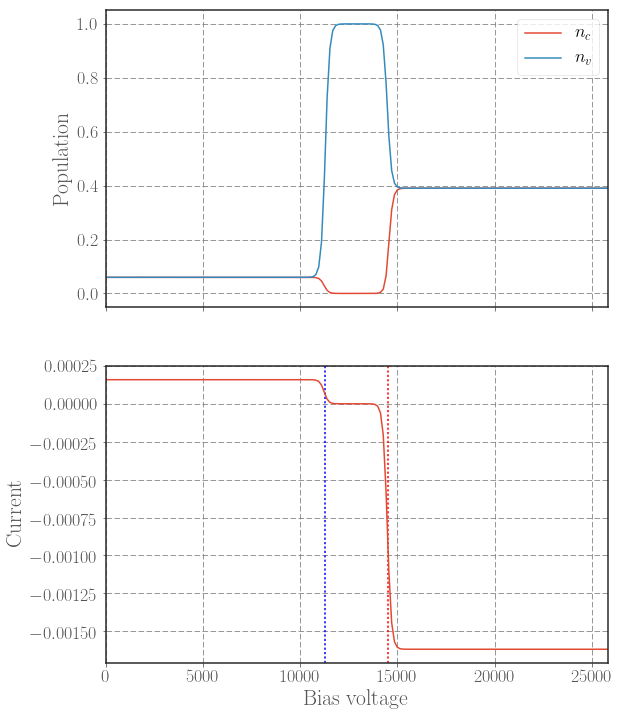

In [122]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0.0, radiative_lifetime=1, alpha_ph=0, mu=600e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_no_BE = populations_and_current_vs_voltage(PARAMS, x_scale=2)
plot_voltage_current(data_dict_no_BE)
#(data_dict_no_BE, y_values='bias_voltage')
plt.savefig("PLOTS/C-V-1a.pdf")
#V_values, I = simple_current_vs_voltage(PARAMS, x_scale=2)
#V_values, Pc, Pv = band_populations_vs_voltage(PARAMS, x_scale=2)

Phonon occupation: 0.00. Phonon thermal energy is 53.51. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 36.4 seconds


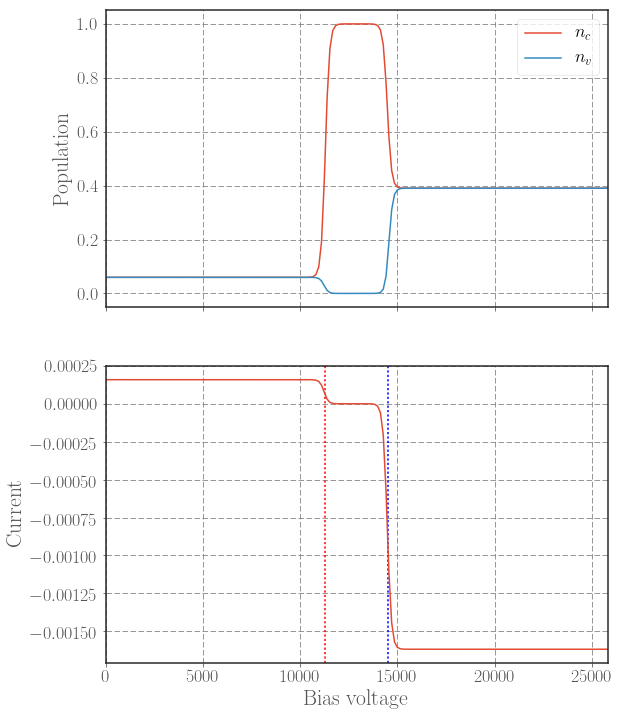

In [123]:
PARAMS = PARAMS_setup(valence_energy=100e-3, binding_energy=0., radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=2, silent=False, T_C=77.)

data_dict_no_BE = populations_and_current_vs_voltage(PARAMS, x_scale=2)
plot_voltage_current(data_dict_no_BE)
#plot_diagrams(data_dict_no_BE, y_values='bias_voltage')
plt.savefig("PLOTS/C-V-1b.pdf")

# Above : no binding energy
The dips in current (from right to left) are when:
- the right-lead chemical potential goes above the conduction band energy (red dotted line).

    - Up to this point the population of the conduction and valence bands is equal
    - Suddenly electrons cannot tunnel off onto the right lead, but they can still fill the valence band from the left lead. This causes zero current to flow.
  
    
- the left-lead chemical potential goes below the valence band energy (blue dotted line).

    - The current goes to zero when there is zero hole population.
    - Suddenly, electrons can tunnel off from the filled valence band onto the left lead which leaves holes.


Phonon occupation: 0.00. Phonon thermal energy is 20.85. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 36.9 seconds


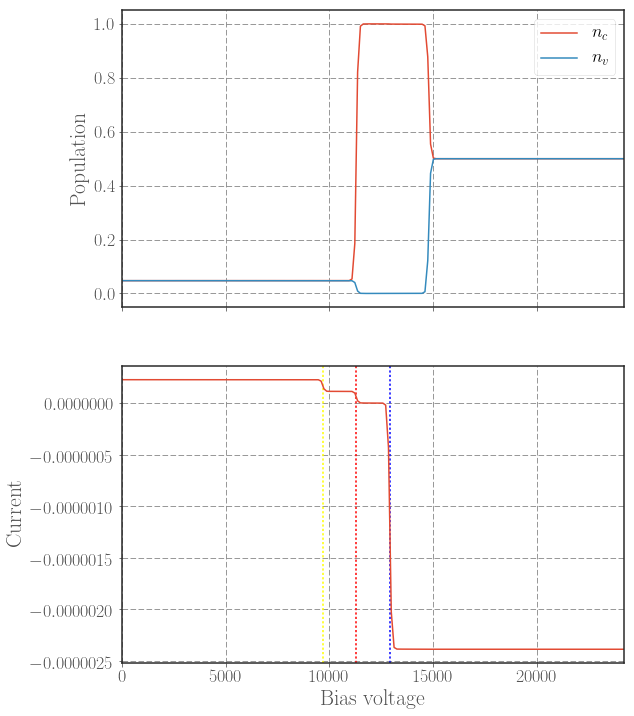

In [128]:
# binding energy SMALLER than 2*mu-bandgap, mu>bandgap/2
PARAMS = PARAMS_setup(binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=2, silent=False, T_C=30.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
#V_values, I = simple_current_vs_voltage(PARAMS, x_scale=2)
#V_values, Pc, Pv = band_populations_vs_voltage(PARAMS, x_scale=2)
#plot_diagrams(data_dict, y_values='bias_voltage')
plot_voltage_current(data_dict)
plt.savefig('PLOTS/C-V-2a.pdf')

Phonon occupation: 0.00. Phonon thermal energy is 20.85. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 35.6 seconds


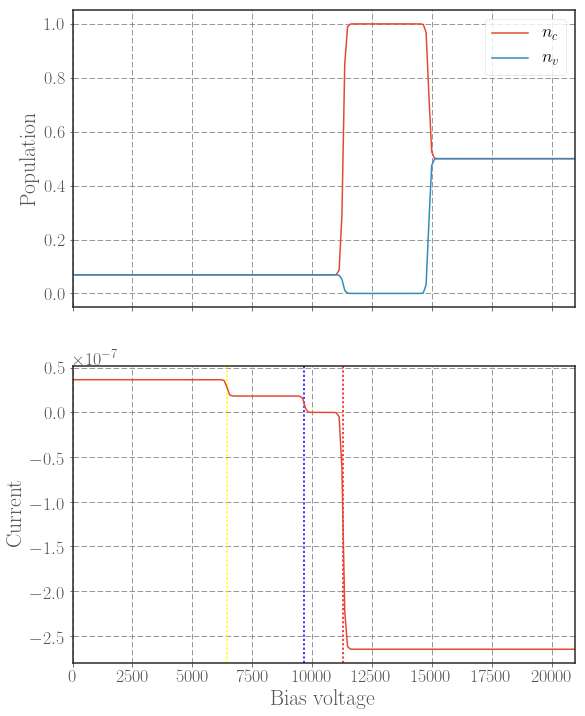

In [129]:
# binding energy LARGER than 2*mu-bandgap, mu>bandgap/2
PARAMS = PARAMS_setup(binding_energy=0.3, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=2, silent=False, T_C=30.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
#V_values, I = simple_current_vs_voltage(PARAMS, x_scale=2)
#V_values, Pc, Pv = band_populations_vs_voltage(PARAMS, x_scale=2)
#plot_diagrams(data_dict, y_values='bias_voltage')
plot_voltage_current(data_dict)
plt.savefig('PLOTS/C-V-2b.pdf')

Phonon occupation: 0.00. Phonon thermal energy is 20.85. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 34.7 seconds


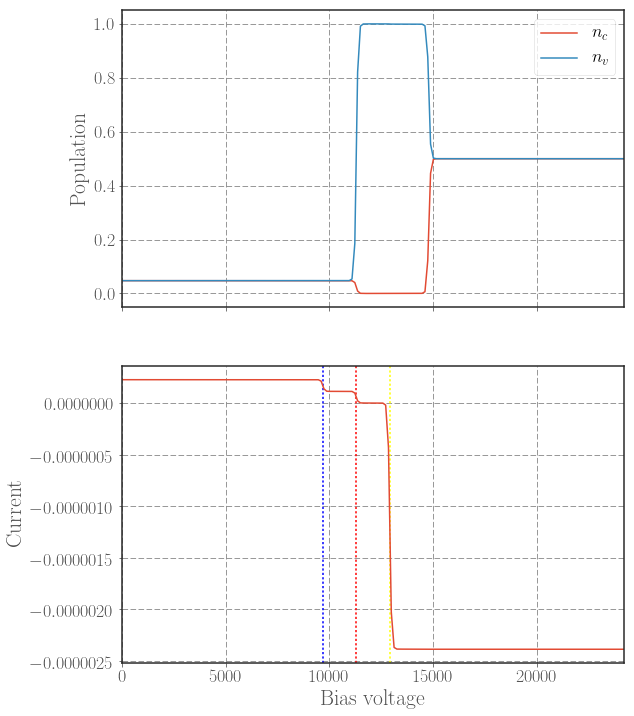

In [130]:
# binding energy SMALLER than 2*mu-bandgap, mu<bandgap/2
PARAMS = PARAMS_setup(binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=600e-3,
                      bias_voltage=0, N=2, silent=False, T_C=30.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
#V_values, I = simple_current_vs_voltage(PARAMS, x_scale=2)
#V_values, Pc, Pv = band_populations_vs_voltage(PARAMS, x_scale=2)
#plot_diagrams(data_dict, y_values='bias_voltage')
plot_voltage_current(data_dict)
plt.savefig('PLOTS/C-V-3a.pdf')

Phonon occupation: 0.00. Phonon thermal energy is 20.85. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 35.6 seconds


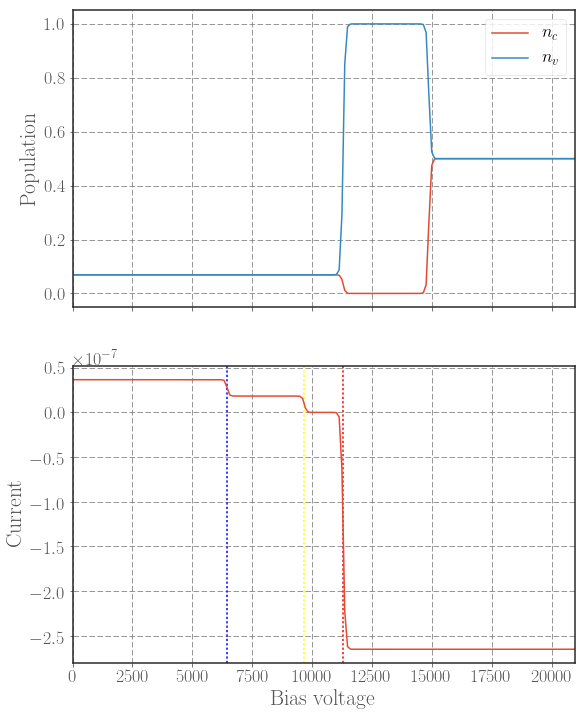

In [131]:
# binding energy LARGER than 2*mu-bandgap, mu<bandgap/2
PARAMS = PARAMS_setup(binding_energy=0.3, radiative_lifetime=1, alpha_ph=0, mu=600e-3,
                      bias_voltage=0, N=2, silent=False, T_C=30.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
#V_values, I = simple_current_vs_voltage(PARAMS, x_scale=2)
#V_values, Pc, Pv = band_populations_vs_voltage(PARAMS, x_scale=2)
#plot_diagrams(data_dict, y_values='bias_voltage')
plot_voltage_current(data_dict)
plt.savefig('PLOTS/C-V-3b.pdf')

# Above: binding energy = $0.2eV$

We can see that, when the right lead chemical potential gets above $\omega_c-\omega_b$, the current decreases. Then again at the conduction band energy.  potential,  the conduction band energy, some current can flow. In order for current to increase any more, $\mu_R$ must remain beyond the binding energy of the exciton.

Slight assymmetry do to fermi-factor assymmetry of *up* and *down* hopping processes.

In [33]:
def short_current(v,c):
    # assumes that V=0 at element 0
    return c[0]

def estimate_Voc(v, c):
    # voltage where current goes to zero
    return v[np.argmin(np.abs(c))]

def power_values(v, c):
    return np.array(v)*np.array(c)

def max_power(v, c):
    # can make this more sophisticated at a later date
    return np.max(power_values(v, c))
def theoretical_max_power(v,c):
    return short_current(v,c)*estimate_Voc(v, c)

def fill_factor(v, c):
    return max_power(v, c)/theoretical_max_power(v,c)

def fill_factor_from_dict(_data_dict):
    return fill_factor(_data_dict['bias_voltages'], _data_dict['current'])

def plot_power(_data_dict):
    current = _data_dict['current']
    
    voltage = _data_dict['bias_voltages']*ev_to_inv_cm
    power = power_values(voltage, current)
    plt.plot(voltage, power)
    plt.axvline(estimate_Voc(voltage, current))
    plt.axhline(max_power(power))
    
def get_photovoltaic_summary(data_dict):
    v, c = data_dict['bias_voltages'], data_dict['current']
    return {"fill-factor": fill_factor_from_dict(data_dict), 
         "V_OC" : estimate_Voc(v, c),
         "I_SC" : short_current(v, c),
         "P_max": max_power(data_dict['bias_voltages'], data_dict['current']),
         "P_theoretical_max": theoretical_max_power(v,c)
        }

Phonon occupation: 0.00. Phonon thermal energy is 20.85. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 34.5 seconds


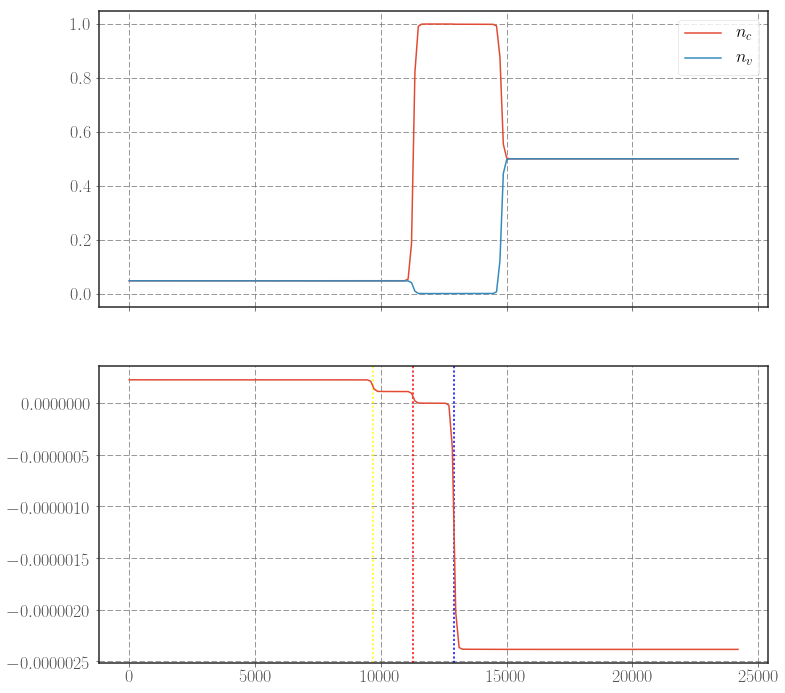

In [45]:
PARAMS = PARAMS_setup(binding_energy=0.1, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=2, silent=False, T_C=30., valence_energy=100e-3)

data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
plot_diagrams(data_dict, y_values='bias_voltage')
get_photovoltaic_summary(data_dict)
plt.savefig("PLOTS/C-V-2.pdf")

Phonon occupation: 0.00. Phonon thermal energy is 20.85. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 35.3 seconds


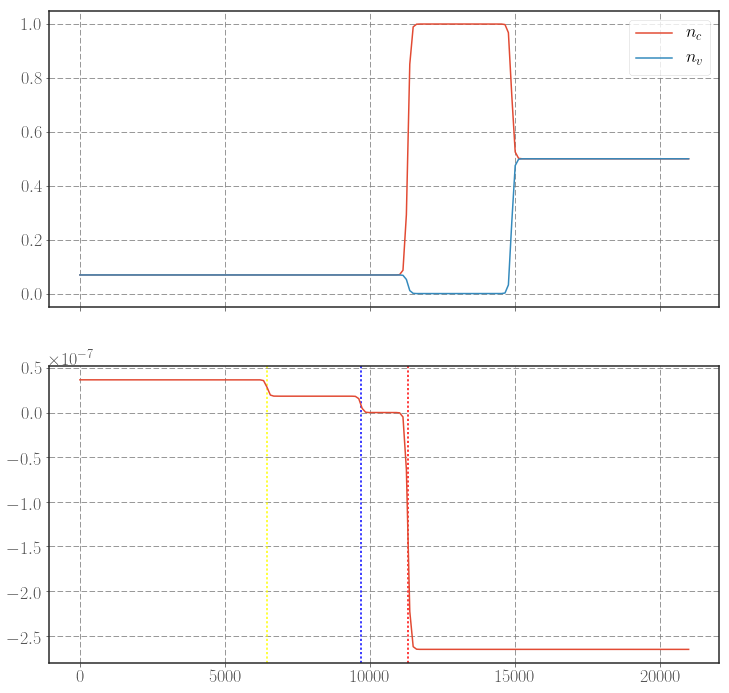

In [46]:
PARAMS = PARAMS_setup(binding_energy=0.3, radiative_lifetime=1, alpha_ph=0, mu=800e-3,
                      bias_voltage=0, N=2, silent=False, T_C=30., valence_energy=100e-3)

data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
plot_diagrams(data_dict, y_values='bias_voltage')
get_photovoltaic_summary(data_dict)
plt.savefig("PLOTS/C-V-3.pdf")

In [37]:
print(2*PARAMS['mu']-PARAMS['bandgap'], PARAMS['binding_energy'])

(1613.1000000000022, 1653.4275)


In [19]:
PARAMS = PARAMS_setup(binding_energy=0.3, valence_energy=100e-3, 
                      radiative_lifetime=1, alpha_ph=0, mu=700e-3,
                      bias_voltage=0, N=2, silent=False, T_C=30.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
print(fill_factor_from_dict(data_dict), estimate_Voc(data_dict['bias_voltages'], data_dict['current']),
      short_current(data_dict['bias_voltages'], data_dict['current']), 
      max_power(data_dict['bias_voltages'], data_dict['current']))

Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 20.1 seconds
(0.74875277736676116, 1.329292929292929, 6.837618577042801e-08, 6.8055622672506377e-08)


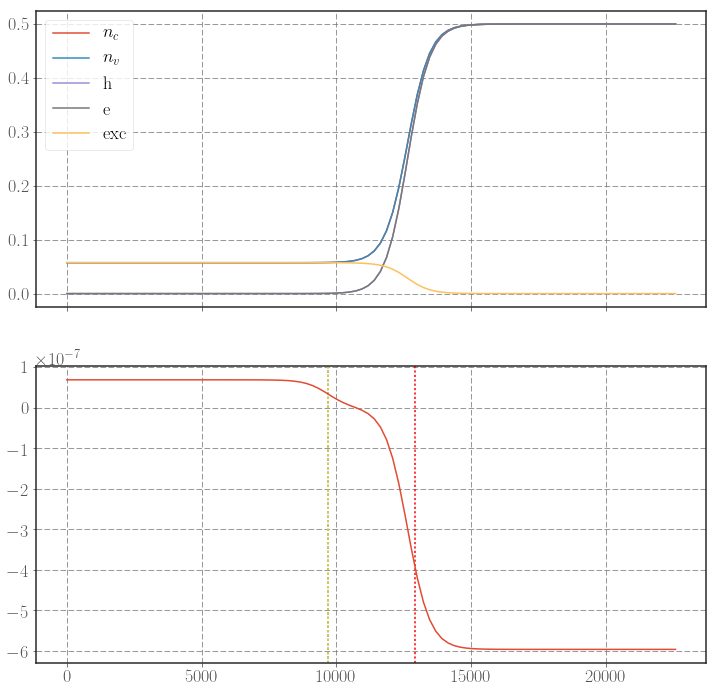

In [20]:
plot_diagrams(data_dict, y_values='bias_voltage')

In [21]:
PARAMS = PARAMS_setup(binding_energy=0.2, valence_energy=100e-3, 
                      radiative_lifetime=1, alpha_ph=0, mu=600e-3,
                      bias_voltage=0, N=2, silent=False, T_C=30.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
print(fill_factor_from_dict(data_dict), estimate_Voc(data_dict['bias_voltages'], data_dict['current']),
      short_current(data_dict['bias_voltages'], data_dict['current']), 
      max_power(data_dict['bias_voltages'], data_dict['current']))

Phonon occupation: 0.17. Phonon thermal energy is 208.50. Phonon SD peak is 0.00. V=0.0. N=2.
C-V data calculated in 19.8 seconds
(0.63398257279134251, 1.329292929292929, 6.83761856399534e-08, 5.7623931391933072e-08)


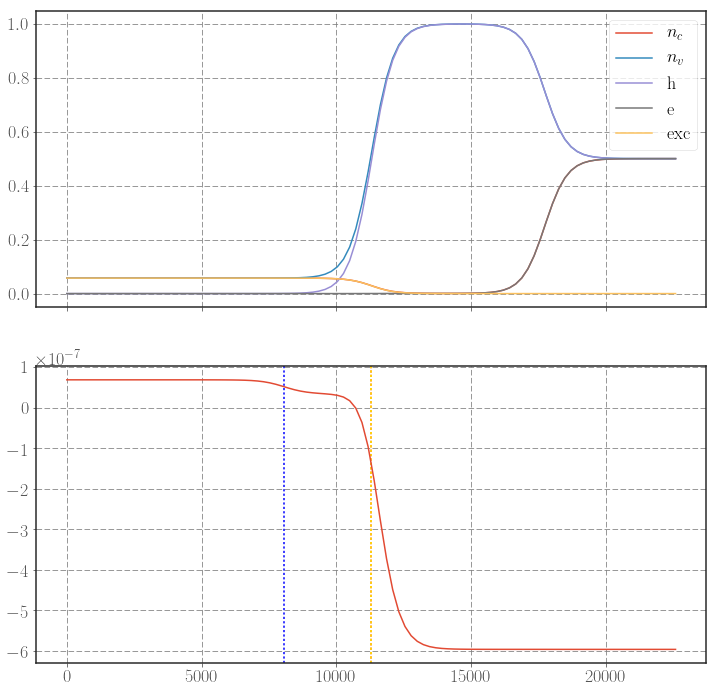

In [22]:
#plot_diagrams(data_dict, y_values='mu_L')
#plot_diagrams(data_dict, y_values='mu_R')
plot_diagrams(data_dict, y_values='bias_voltage')

Here we see the effect that the blue and yellow lines are equal at $\mu < (\omega_c - \omega_v)/2$, which is the point that the expression for the red line breaks down. The yellow line represents the point where $\mu_L>\omega_c-U$. Suppose an exciton is created, the chemical potential of the right lead only needs to be $\omega_c-U$ for electrons to tunnel on, this decreases the current.


## In summary
Although changing $\mu$ does not seem to change $V_{OC}$ or $I_{SC}$, it seems that you can enhance maximum power and filling-factor by getting the blue and yellow lines to coincide.

In [ ]:
plot_power(data_dict)

# Test phonons and non-additive code

In [ ]:
#base params
PARAMS = PARAMS_setup(binding_energy=0.2, valence_energy=100e-3, 
                      radiative_lifetime=1, alpha_ph=50e-3, mu=800e-3,
                      bias_voltage=0, N=8, silent=False, T_C=300.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
save_obj(data_dict, 'DATA/C-V/data_dict_1_10mev')
print(fill_factor_from_dict(data_dict), estimate_Voc(data_dict['bias_voltages'], data_dict['current']),
      short_current(data_dict['bias_voltages'], data_dict['current']), 
      max_power(data_dict['bias_voltages'], data_dict['current']))
plot_diagrams(data_dict, y_values='bias_voltage')

In [ ]:
plot_power(data_dict)

In [ ]:
# smaller mu (at threshold)
PARAMS = PARAMS_setup(binding_energy=0.2, valence_energy=100e-3, 
                      radiative_lifetime=1, alpha_ph=50e-3, mu=700e-3,
                      bias_voltage=0, N=8, silent=False, T_C=300.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
save_obj(data_dict, 'DATA/C-V/data_dict_2_10mev')
print(fill_factor_from_dict(data_dict), estimate_Voc(data_dict['bias_voltages'], data_dict['current']),
      short_current(data_dict['bias_voltages'], data_dict['current']), 
      max_power(data_dict['bias_voltages'], data_dict['current']))
plot_diagrams(data_dict, y_values='bias_voltage')

In [ ]:
# stronger phonon coupling
PARAMS = PARAMS_setup(binding_energy=0.2, valence_energy=100e-3, 
                      radiative_lifetime=1, alpha_ph=100e-3, mu=800e-3,
                      bias_voltage=0, N=10, silent=False, T_C=300.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
save_obj(data_dict, 'DATA/C-V/data_dict_3_10mev')
print(fill_factor_from_dict(data_dict), estimate_Voc(data_dict['bias_voltages'], data_dict['current']),
      short_current(data_dict['bias_voltages'], data_dict['current']), 
      max_power(data_dict['bias_voltages'], data_dict['current']))
plot_diagrams(data_dict, y_values='bias_voltage')

In [ ]:
#larger valence and conduction energy
PARAMS = PARAMS_setup(binding_energy=0.2, valence_energy=200e-3, 
                      radiative_lifetime=1, alpha_ph=50e-3, mu=800e-3,
                      bias_voltage=0, N=8, silent=False, T_C=300.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
save_obj(data_dict, 'DATA/C-V/data_dict_4_10mev')
print(fill_factor_from_dict(data_dict), estimate_Voc(data_dict['bias_voltages'], data_dict['current']),
      short_current(data_dict['bias_voltages'], data_dict['current']), 
      max_power(data_dict['bias_voltages'], data_dict['current']))
plot_diagrams(data_dict, y_values='bias_voltage')

In [ ]:
# colder
PARAMS = PARAMS_setup(binding_energy=0.2, valence_energy=100e-3, 
                      radiative_lifetime=1, alpha_ph=50e-3, mu=800e-3,
                      bias_voltage=0, N=8, silent=False, T_C=200.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
save_obj(data_dict, 'DATA/C-V/data_dict_5_10mev')
print(fill_factor_from_dict(data_dict), estimate_Voc(data_dict['bias_voltages'], data_dict['current']),
      short_current(data_dict['bias_voltages'], data_dict['current']), 
      max_power(data_dict['bias_voltages'], data_dict['current']))
plot_diagrams(data_dict, y_values='bias_voltage')

In [ ]:
# longer radiative lifetime
PARAMS = PARAMS_setup(binding_energy=0.2, valence_energy=100e-3, 
                      radiative_lifetime=2, alpha_ph=50e-3, mu=800e-3,
                      bias_voltage=0, N=8, silent=False, T_C=300.)
data_dict = populations_and_current_vs_voltage(PARAMS, x_scale=2)
save_obj(data_dict, 'DATA/C-V/data_dict_6_10mev')
print(fill_factor_from_dict(data_dict), estimate_Voc(data_dict['bias_voltages'], data_dict['current']),
      short_current(data_dict['bias_voltages'], data_dict['current']), 
      max_power(data_dict['bias_voltages'], data_dict['current']))
plot_diagrams(data_dict, y_values='bias_voltage')

In [ ]:
# all these say 10mev on the filnemae but they are mostly 50mev